# Data science in Neuroscience


## Plan for today

1. Review of last week's exercises
2. Why and how are in-vivo recordings performed?
3. Extracting action potentials from raw signals
    * Filtering
    * Identifying spikes
    * Extracting spike waveforms
    * Dimensionality reduction
    * Clustering spike waveforms

***

## Review of last week's exercises

Reload the data from last week.

The is a recording from 8 electrodes/channels for 1 second at 20 000 Hz. 

In [63]:
import numpy as np
import matplotlib.pyplot as plt

fileName = "../data/shortRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

* What do you think the electrodes are measuring? 
* How many dimensions does the data have?
* What is the size of the array in each dimension?
* What is the data type or dtype (integer, float, etc.) of the `dat` array?
* Which dimension represents the recording channels and the recording samples?

In [64]:
(dat.ndim,dat.shape,dat.dtype)

(2, (8, 20000), dtype('int16'))

* Plot the data for the first recording channel.
* Do you seen any oscillatory patterns in the data? If so at which frequency? 
* Plot the data for 2 recording channels. 
* What is similar or different between the different channels?

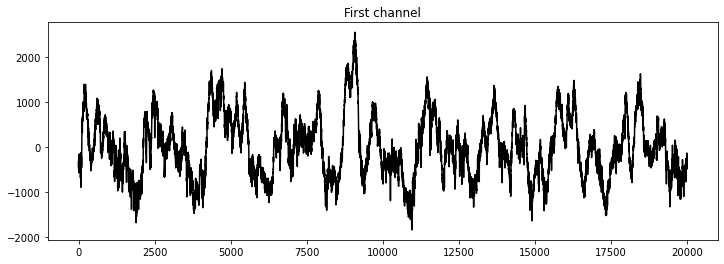

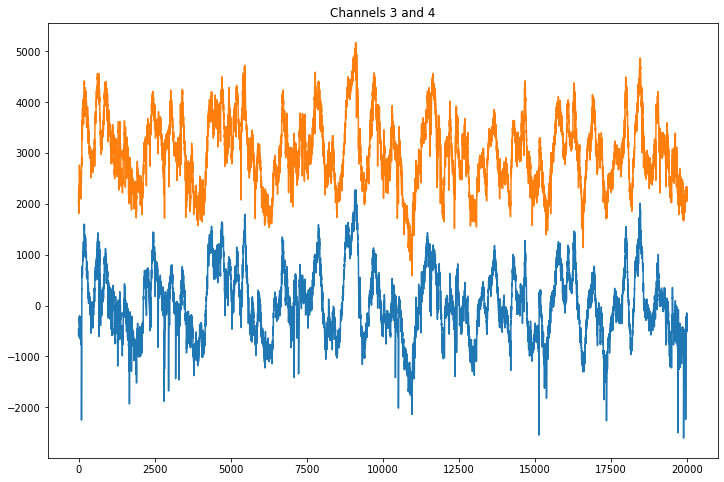

In [65]:
# plot the first channel
plt.figure(figsize=(12,4))
plt.plot(dat[0,:],c="black")
plt.title("First channel")
plt.show()

# plot 2 channels
plt.figure(figsize=(12,8))
plt.plot(dat[3,:])
plt.plot(dat[4,:]+3000) # I added 3000 to the values of channel 4 to be able to see it.
plt.title("Channels 3 and 4")
plt.show()

* What is the mean value in the `dat` array?
* What is the mean value per channel of the `dat` array?
* Can you plot the mean value across channels for all samples? The plot should have 20000 values.
* How could I had 100 to all values in the array?
* Which channel has the largest standard deviation?
* Can you plot the distribution of values for the second recording channel?
* For each channel, remove the mean from every data point.


In [66]:
print("The mean of dat is :",dat.mean())
print("Mean per channel:")
print(dat.mean(axis=1))

The mean of dat is : 3.06385
Mean per channel:
[ -9.30035  18.965   -14.9138   28.8605   16.56955  29.91675 -33.8044
 -11.78245]


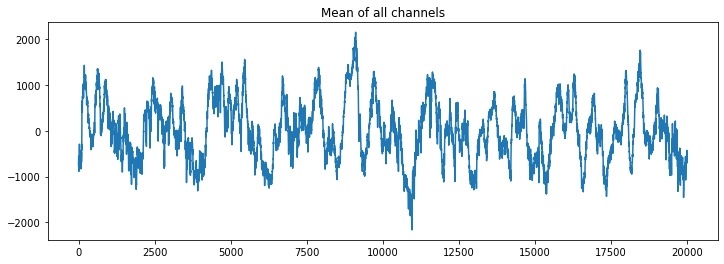

In [67]:
plt.figure(figsize=(12,4))
plt.plot(dat.mean(axis=0))
plt.title("Mean of all channels")
plt.show()

In [68]:
dat+100
print("Standard deviation per channel:")
print(dat.std(axis=1))
      
print("Channel with the largest standard deviation")
print(np.argmax(dat.std(axis=1))) # note the use of np.argmax()

Standard deviation per channel:
[676.37638925 676.71487369 682.68302745 669.85032936 688.10030647
 641.68837049 673.63273573 651.19369954]
Channel with the largest standard deviation
4


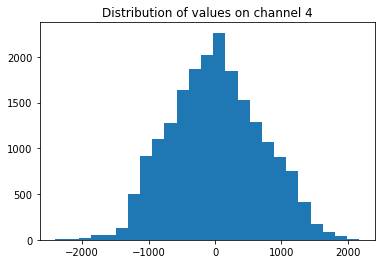

In [69]:
plt.hist(dat[4,:],bins=25)
plt.title("Distribution of values on channel 4")
plt.show()

***

# Why and how are in-vivo recordings performed?

**Aim:** Monitor the activity of groups of neurons during behavior. 

The correlation between cell activity and behavior informs us about the potential role of a brain area for behavior. We can learn how information is processed within neuronal circuits.

## Why: Spatially selective neurons in the medial entorhinal cortex (MEC)

By recording the activity of neurons in the entorhinal cortex in freely-moving mice, scientists discovered that MEC neurons encode where the animal is in its environment and in which direction it is heading. This brain region is essential for navigation.


<div>
<img src="../images/mec_neurons.png" width="400"/>
</div>


* Hafting et al., 2005. Microstructure of a spatial map in the entorhinal cortex. Nature
* Sargolini et al., 2006. Conjunctive Representation of Position, Direction, and Velocity in Entorhinal Cortex. Nature
* Gil et al., 2018. Impaired path integration in mice with disrupted grid cell firing. Nature Neuroscience

## How: Electrodes -> Amplifier -> Digitalization -> Recording on disk

Electrodes located in the extracellular space can pick up action potentials from several neurons. 

<div>
<img src="../images/buzsaki_tetrode_in_layer.jpg" width="600"/>
</div>


<div>
<img src="../images/buzsaki_probe.webp" width="800"/>
</div>

<div>
<img src="../images/intan_64.jpg" width="300"/>
</div>


* Buzsaki, 2004. Large-scale recording of neuronal ensembles. Nature Neuroscience
* Steinmetz et al., 2021. Neuropixels 2.0: A miniaturized high-density probe for stable, long-term brain recordings. Science
* https://intantech.com/


The recording system sample the voltage on multiple channels at 20-30 kHz. The amplified signal is saved to disk for later analysis.

***

# Extracting action potentials from raw signals

To study the activity of single neurons, we need to find at which time which neuron was spiking. 


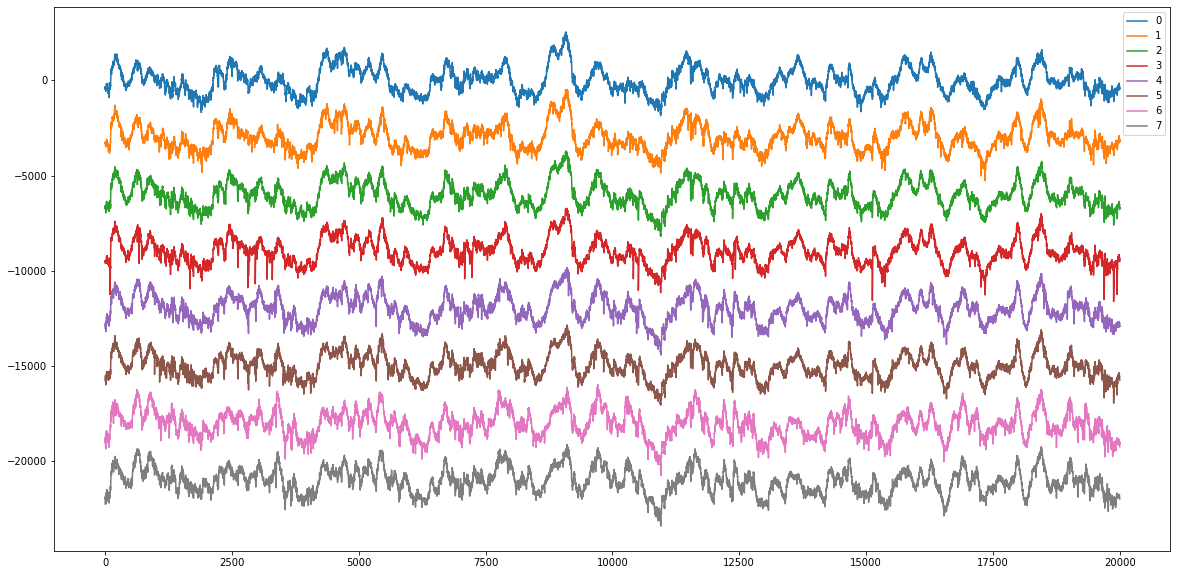

In [167]:
offset=3000 #y-shift between channels when plotting the data
plt.figure(figsize=(20,10)) # set the size of the figure

for i in range(y.shape[0]): #loop for every channel
    plt.plot(dat[i,:]-i*3000,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
plt.legend()
plt.show()

* Filtering
* Identifying spikes
* Extracting spike waveforms
* Dimensionality reduction
* Clustering spike waveforms

## Filtering

The signal recorded is the sum of several components: 

1. Large amplitude spikes of a few neurons close to the recording sites
2. Small amplitude spikes of many distant neurons
3. Fluctuations in synaptic currents onto thousands of neurons
4. Electrical noise 
5. Head muscle contractions (e.g., noise associated with chewing)
6. Motion artifacts

If a neuron is close enough to our electrodes, its action potentials create rapid (usually) negative deflections in the signal. The spikes in extracellular space last less than 1 ms.

To extract action potentials, we need to separate these fast negative deflections from other slower components of the signal. That is why we need to filter the signal.


### Create a Butterworth filter

We eliminate low-frequency oscillations (below 300 Hz) and keep faster oscillations (including spikes).

In [70]:
from scipy.signal import butter, sosfreqz , sosfilt

In [71]:
fs = 20000 # sampling rate

In [72]:
def create_butter_highpass_filter(lowcut, fs, order=3):
    """
    Create a Butterworth filter using scipy.signal.butter()
    """
    nyq = 0.5 * fs # Nyquist frequency (sampling rate/2)
    low = lowcut / nyq # lowcut as a proportion of Nyquist frequency
    sos = butter(order, [low], btype='highpass' ,  output='sos') #‘sos’ should be used for general-purpose filtering.
    return sos


In [73]:
lowcut=300
myFilter = create_butter_highpass_filter(lowcut = lowcut,fs=fs, order=3)

### Display the frequency response of the filter

It should be near 0 and flat at the frequencies that you want to keep.

In [74]:
# calculate the frequency response of our filter for visualization
w, h = sosfreqz(myFilter, worN=1500)

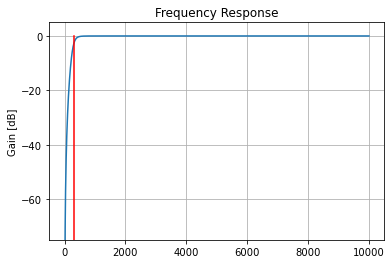

In [75]:
db = 20*np.log10(np.maximum(np.abs(h), 1e-5)) # don't worry about this, transforms data in dB.
plt.plot(w/np.pi*fs/2, db)
plt.ylim(-75, 5)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.plot([lowcut,lowcut],[-75,0],c="red")
plt.show()

## Apply the fitler to a recording channel

We can apply our filter

In [155]:
chan=3
y = sosfilt(myFilter, dat[chan,:]) # we filter the raw data from channel 3 and save the results in y
print(y.shape, dat[chan,:].shape) # y has same shape as the raw data from channel 3

(20000,) (20000,)


Plot the raw and filtered signals

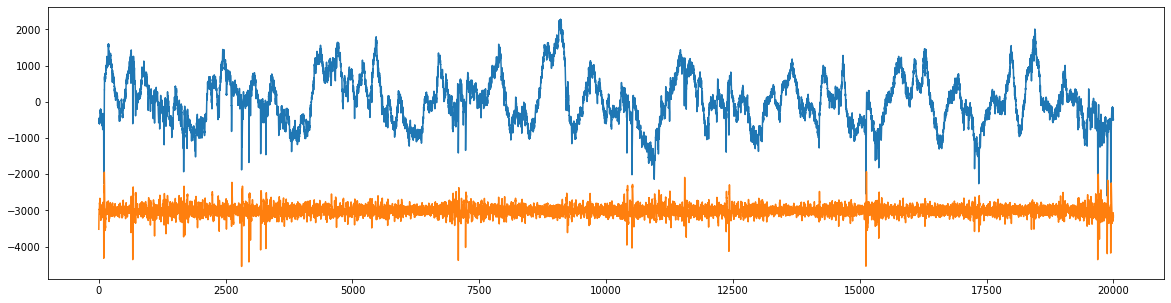

In [157]:
nSamples=20000
plt.figure(figsize=(20,5))
plt.plot(dat[chan,0:nSamples])
plt.plot(y[0:nSamples]-3000)
plt.show()

Plot fewer data points to zoom in on the raw and filtered signals. 

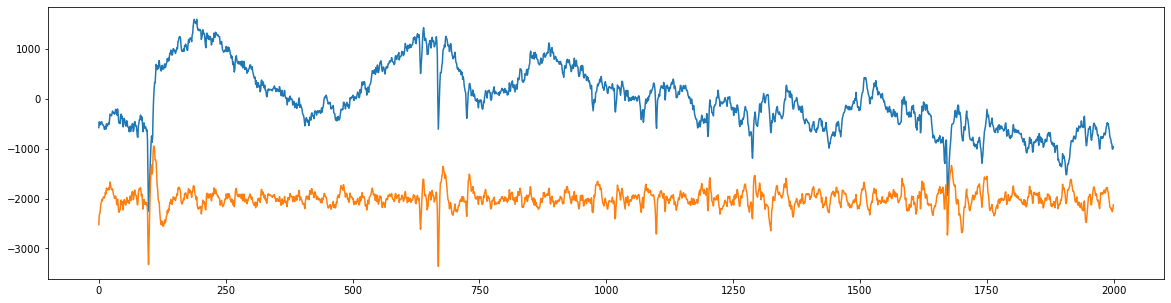

In [159]:
nSamples=2000
plt.figure(figsize=(20,5))
plt.plot(dat[chan,0:0+nSamples])
plt.plot(y[0:0+nSamples]-2000)

We can apply the filter to all of our channels. Luckily, the sosfilt() function can take 2D arrays as input, so we can filter 8 channels with one line.

In [163]:
y = sosfilt(myFilter, dat) # the sosfilt() function can take a 2D array and will filter every row separately
y.shape # y now contains our 8 channels

(8, 20000)

Don't just assume that the filter was applied to all channels, plot it to be sure.

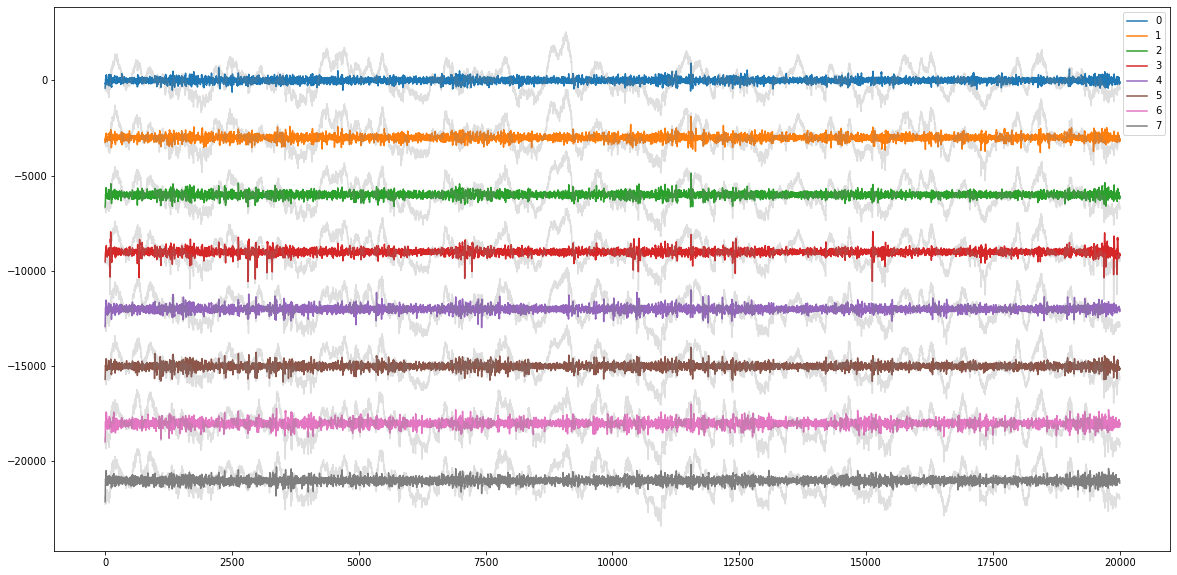

In [164]:
offset=3000 #y shift between channels
plt.figure(figsize=(20,10))

for i in range(y.shape[0]): #loop for every channel
    plt.plot(y[i,:]-i*3000,label=i) # plot the filtered data
    plt.plot(dat[i,:]-i*3000,c="gray",alpha=0.25) # plot original signal in transparent gray
plt.legend()
plt.show()

## Identifying spikes

We have removed slow owcillations from the raw signal. We can try to identify spikes in the filtered signal.

One simple strategy is to calculate the mean and standard deviation of the filtered. A spikes occures each time the signal reaches 5 standard deviation from the mean. This is the __spike detection threshold__.

In [165]:
chan=3 # select a channel to work with
mean=y[3,:].mean()
std=y[3,:].std()
z=5 # 5 std below the mean

We can plot the filtered data for one channel and the spike detection threshold. 

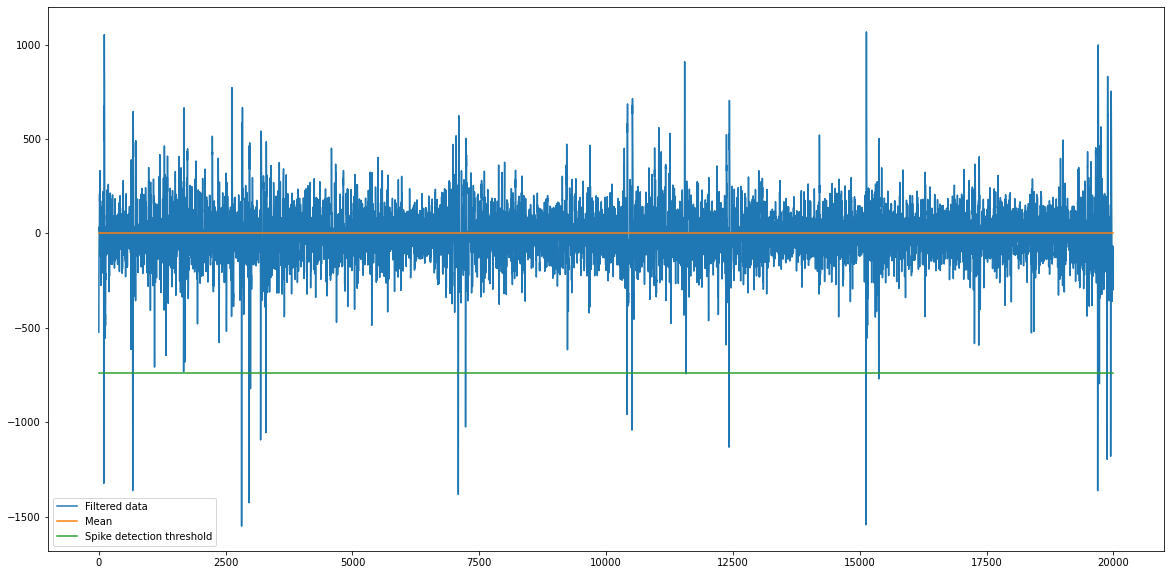

In [166]:
plt.figure(figsize=(20,10))
plt.plot(y[chan,:],label="Filtered data")
plt.plot([0,y.shape[1]],[mean,mean], label="Mean")
plt.plot([0,y.shape[1]],[mean-z*std,mean-z*std], label="Spike detection threshold")
plt.legend()
plt.show()

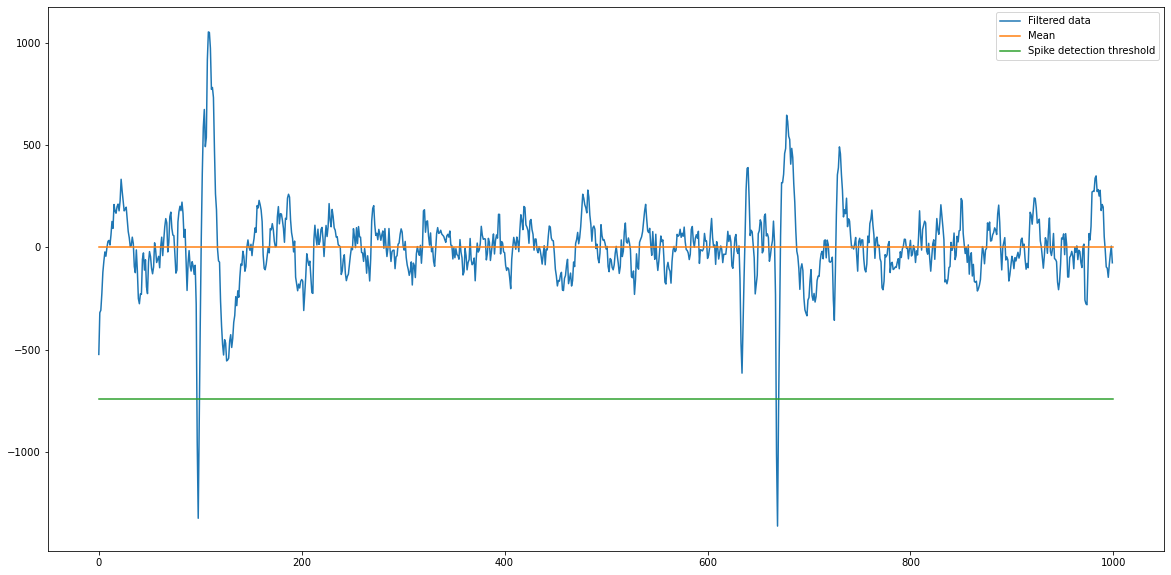

In [151]:
nSamples=1000
plt.figure(figsize=(20,10))
plt.plot(y[chan,:nSamples],label="Filtered data")
plt.plot([0,nSamples],[mean,mean],label="Mean")
plt.plot([0,nSamples],[mean-z*std,mean-z*std],label="Spike detection threshold")
plt.legend()
plt.show()

We now need to find the trough of the detected spikes. One trick is to set all the data below threshold to 0, and find the negative peaks in the signal.

[-3.51574601e-02 -3.48499000e-02 -5.05670851e-02 -1.03121509e-01
  1.01696146e-04 -7.46585256e-02 -2.06154819e-03 -1.23255651e-02]
[115.49561516 134.20127679 126.59942781 147.83219958 138.93405864
 137.42158165 153.62266104 136.66285144]


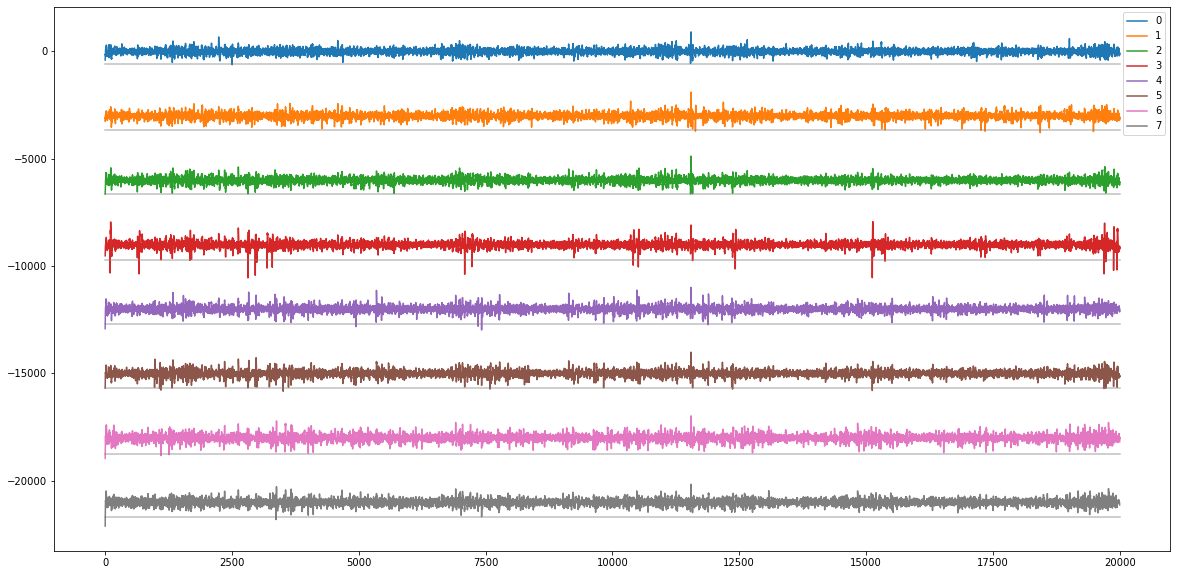

In [124]:
chan=3 # select a channel to work with
means=y.mean(axis=1)
stds=y.std(axis=1)
print(means)
print(stds)
z=5
offset=3000 #y shift between channels
plt.figure(figsize=(20,10))
for i in range(y.shape[0]): #loop for every channel
    ofs=i*3000
    plt.plot(y[i,:]-ofs,label=i)
    plt.plot([0,y.shape[1]],[mean[i]-z*std[i]-ofs,mean[i]-z*std[i]-ofs],c="gray",alpha=0.5)
plt.legend()
plt.show()

In [84]:
from scipy.signal import find_peaks